In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

postgresql_jdbc_jar = r"C:/Program Files/PostgreSQL/17/postgresql-42.7.4.jar"
spark = SparkSession.builder.appName('modeldevelopment')\
                            .config("spark.jars", postgresql_jdbc_jar) \
                            .config("spark.driver.extraClassPath", postgresql_jdbc_jar) \
                            .config("spark.driver.memory", "8g")\
                            .config("spark.executor.memory", "8g")\
                            .config("spark.executor.cores", "4")\
                            .getOrCreate()

### Reading the data

In [2]:
# Database connection parameters
url = "jdbc:postgresql://localhost:5432/postgres"
properties = {
    "user": "postgres",
    "password": "root",
    "driver": "org.postgresql.Driver"
}

# Load the data into a PySpark DataFrame
df_p = spark.read.jdbc(url=url, table='feature_engineering_delivery', properties=properties)
df_c = spark.read.jdbc(url=url, table='delivery_data', properties=properties)

df_c_selected = df_c.select('order_id', 'delivery_time', 'city', 'accept_time', 'lng', 'lat')

df_model = df_p.join(df_c_selected, on='order_id', how='left')

In [3]:
df_model.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- delivery_eta_minutes: double (nullable = true)
 |-- delivery_time_delay: double (nullable = true)
 |-- delivery_distance_km: double (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- avg_delivery_time_minutes: double (nullable = true)
 |-- delivery_order_count: integer (nullable = true)
 |-- city_order_count: integer (nullable = true)
 |-- is_delayed: string (nullable = true)
 |-- speed_kmh: integer (nullable = true)
 |-- speed_status: string (nullable = true)
 |-- pca1: double (nullable = true)
 |-- pca2: double (nullable = true)
 |-- pca3: double (nullable = true)
 |-- pca4: double (nullable = true)
 |-- pca5: double (nullable = true)
 |-- pca6: double (nullable = true)
 |-- pca7: double (nullable = true)
 |-- pca8: double (nullable = true)
 |-- pca9: double (nullable = true)
 |-- pca10: double (nu

###  Train-Test Split – Using a time-based split for proper validation

In [4]:
# Convert 'delivery_time' to timestamp format if it's not already in that format
df_model = df_model.withColumn("delivery_time", to_timestamp(col("delivery_time")))

# Sort the dataframe by 'delivery_time' (or any other relevant time column)
df_sorted = df_model.orderBy("delivery_time")

# Get the minimum and maximum 'delivery_time' from the data
min_date = df_sorted.agg(min("delivery_time")).collect()[0][0]
max_date = df_sorted.agg(max("delivery_time")).collect()[0][0]

# Calculate the total duration between the min and max dates
duration = max_date - min_date

# Calculate 80% of the duration for the training data
train_duration = duration * 0.8

# Define the cutoff date, which is 80% of the total time range from min_date
cutoff_date = min_date + train_duration

# Split the data into training and testing based on the cutoff date
train_data = df_sorted.filter(col("delivery_time") < cutoff_date)
test_data = df_sorted.filter(col("delivery_time") >= cutoff_date)

# Show the size of the training and testing datasets
print(f"Training data size: {train_data.count()}")
print(f"Testing data size: {test_data.count()}")

# Check the distribution of the 'is_delayed' column in both datasets (if it's a categorical target)
train_delayed_count = train_data.groupBy("is_delayed").count().show()
test_delayed_count = test_data.groupBy("is_delayed").count().show()

Training data size: 2385767
Testing data size: 267294
+----------+-------+
|is_delayed|  count|
+----------+-------+
|   On Time|2164877|
|   Delayed| 220890|
+----------+-------+

+----------+------+
|is_delayed| count|
+----------+------+
|   On Time|233425|
|   Delayed| 33869|
+----------+------+



### Model Selection:

#### Regression models for ETA prediction (XGBoost, Random Forest, Linear Regression).

In [5]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Estimator
from pyspark.sql.functions import col
import numpy as np
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyspark.ml import Pipeline

##### ETA prediction using XGBoost, Random Forest, Linear Regression

In [6]:
# Initialize the StringIndexer to convert the categorical 'speed_status' column to numeric
speed_status_indexer = StringIndexer(inputCol="speed_status", outputCol="speed_status_indexed")

#Prepare features and target variable
features = ['hour_of_day', 'day_of_week', 'month', 'delivery_time_delay', 'delivery_distance_km',
            'cluster', 'avg_delivery_time_minutes', 'delivery_order_count', 'city_order_count', 
            'speed_kmh', 'speed_status_indexed']

# Use VectorAssembler to combine feature columns into a single vector column for ML algorithms
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create a pipeline that first applies the StringIndexer and then the VectorAssembler
pipeline = Pipeline(stages=[speed_status_indexer, assembler])

# Apply the pipeline to the training and test datasets
train_data_features = pipeline.fit(train_data).transform(train_data)
test_data_features = pipeline.fit(test_data).transform(test_data)

In [7]:
# Model 1: Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='delivery_eta_minutes')
lr_model = lr.fit(train_data_features)
lr_predictions = lr_model.transform(test_data_features)

# Model 2: Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='delivery_eta_minutes')
rf_model = rf.fit(train_data_features)
rf_predictions = rf_model.transform(test_data_features)

# XGBoost Regressor (scikit-learn version)
# Convert train_data and test_data to Pandas DataFrame for scikit-learn models
train_df = train_data_features.select("features", 'delivery_eta_minutes').toPandas() # delivery_eta_minutes is the target
test_df = test_data_features.select("features", 'delivery_eta_minutes').toPandas() # delivery_eta_minutes is the target

# Convert the 'features' column from PySpark vector format to a list of numbers for scikit-learn
X_train = np.array(train_df['features'].tolist())
y_train = np.array(train_df['delivery_eta_minutes'])
X_test = np.array(test_df['features'].tolist())
y_test = np.array(test_df['delivery_eta_minutes'])

# Initialize and train XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# XGBoost Predictions
xgb_predictions = xgb.predict(X_test)

In [8]:
# Evaluate the models using RMSE, MSE, and MAE
evaluator = RegressionEvaluator(labelCol="delivery_eta_minutes", predictionCol="prediction", metricName="rmse")

# Linear Regression Evaluation
rmse_lr = evaluator.evaluate(lr_predictions)
mse_lr = mean_squared_error(y_test, lr_predictions.select('prediction').toPandas())
mae_lr = mean_absolute_error(y_test, lr_predictions.select('prediction').toPandas())

# Random Forest Evaluation
rmse_rf = evaluator.evaluate(rf_predictions)
mse_rf = mean_squared_error(y_test, rf_predictions.select('prediction').toPandas())
mae_rf = mean_absolute_error(y_test, rf_predictions.select('prediction').toPandas())

# XGBoost Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))  # RMSE for XGBoost
mse_xgb = mean_squared_error(y_test, xgb_predictions)  # MSE for XGBoost
mae_xgb = mean_absolute_error(y_test, xgb_predictions)  # MAE for XGBoost

# Print evaluation results
print("Model Evaluation Results:")
print(f"Linear Regression - RMSE: {rmse_lr}, MSE: {mse_lr}, MAE: {mae_lr}")
print(f"Random Forest - RMSE: {rmse_rf}, MSE: {mse_rf}, MAE: {mae_rf}")
print(f"XGBoost - RMSE: {rmse_xgb}, MSE: {mse_xgb}, MAE: {mae_xgb}")

Model Evaluation Results:
Linear Regression - RMSE: 1.9112717886035958e-13, MSE: 3.6529598499119886e-26, MAE: 4.8716969118654843e-14
Random Forest - RMSE: 717.7574527450452, MSE: 515175.76097105606, MAE: 85.16307103320648
XGBoost - RMSE: 4250.674623972448, MSE: 18068234.75888331, MAE: 89.32148447828727


In [9]:
#looking the values of RMSE, MSE, MAE for each model, all three values are lowest for XGBOOST so this is he best fit model.

##### Hyperparameter Tuning & Evaluation for XGBOOST – Optimizing model performance.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc

# Collect Garbage
gc.collect()

# Define XGBoost Regressor Model with GPU
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [75, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6, 7],
    'min_child_weight': [2, 3],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0]
}

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV( estimator=xgb_model, param_distributions=param_grid_xgb,
                                        n_iter=10, cv=4, n_jobs=2, verbose=2, scoring='neg_mean_squared_error',  # Regression Metric
                                        random_state=42
)

# Fit RandomizedSearchCV
random_search_xgb.fit(X_train, y_train)

# Best Hyperparameters
print("Best Hyperparameters:", random_search_xgb.best_params_)

# Get the Best Model
xgb_best = random_search_xgb.best_estimator_

# Predictions
xgb_predictions = xgb_best.predict(X_test)

# Evaluation Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))
mse_xgb = mean_squared_error(y_test, xgb_predictions)
mae_xgb = mean_absolute_error(y_test, xgb_predictions)

print("\n XGBoost Performance after Hyperparameter Tuning:")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters: {'subsample': 0.5, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.4}

 XGBoost Performance after Hyperparameter Tuning:
RMSE: 2148.4850
MSE: 4615987.9012
MAE: 106.7725


##### Feature Importance Analysis – Using SHAP values & Feature Importance plots to interpret results

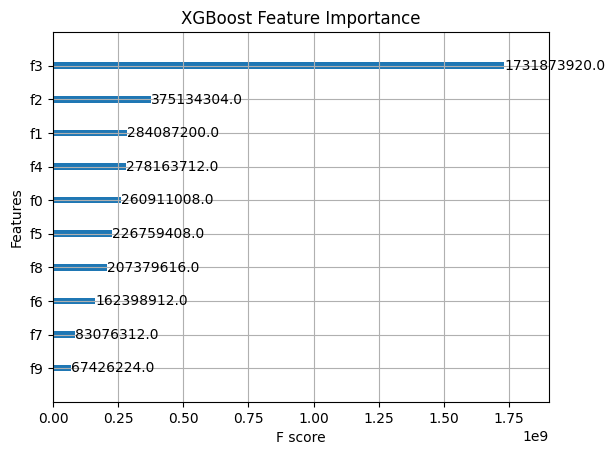

100%|===================| 238040/238577 [06:45<00:00]        

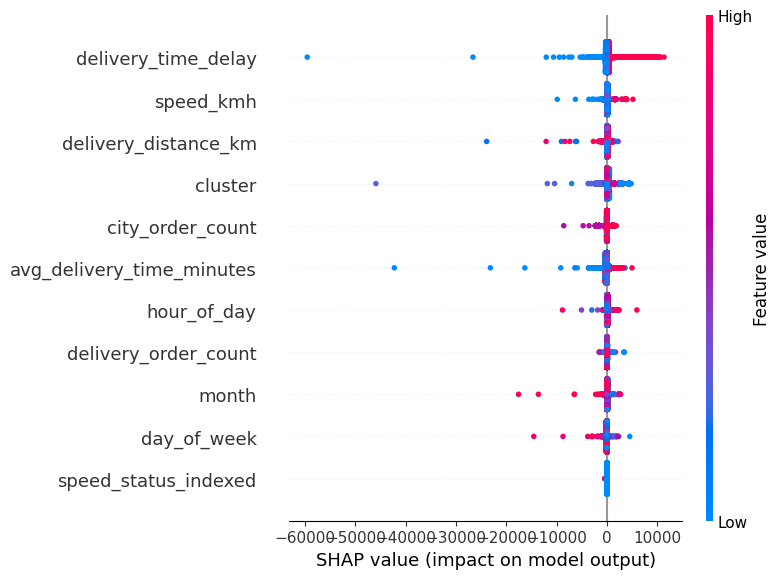

In [11]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# XGBoost Feature Importance
xgb.plot_importance(xgb_best, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=features) 
    
# Take 10% random sample from X_train
X_sample = X_train.sample(frac=0.1, random_state=42)  # random_state for reproducibility

# Create SHAP explainer with sampled data
explainer = shap.TreeExplainer(xgb_best, X_sample)
shap_values = explainer.shap_values(X_sample)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_sample)

shap.initjs()
# SHAP Force Plot for first prediction (Expected Value for Regression)
shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0, :])

                     Feature  SHAP Importance
3        delivery_time_delay       137.347828
9                  speed_kmh        24.193545
4       delivery_distance_km        17.499013
5                    cluster        17.128751
8           city_order_count        10.562557
6  avg_delivery_time_minutes         8.721196
0                hour_of_day         7.410890
7       delivery_order_count         6.314633
2                      month         5.955717
1                day_of_week         3.613363


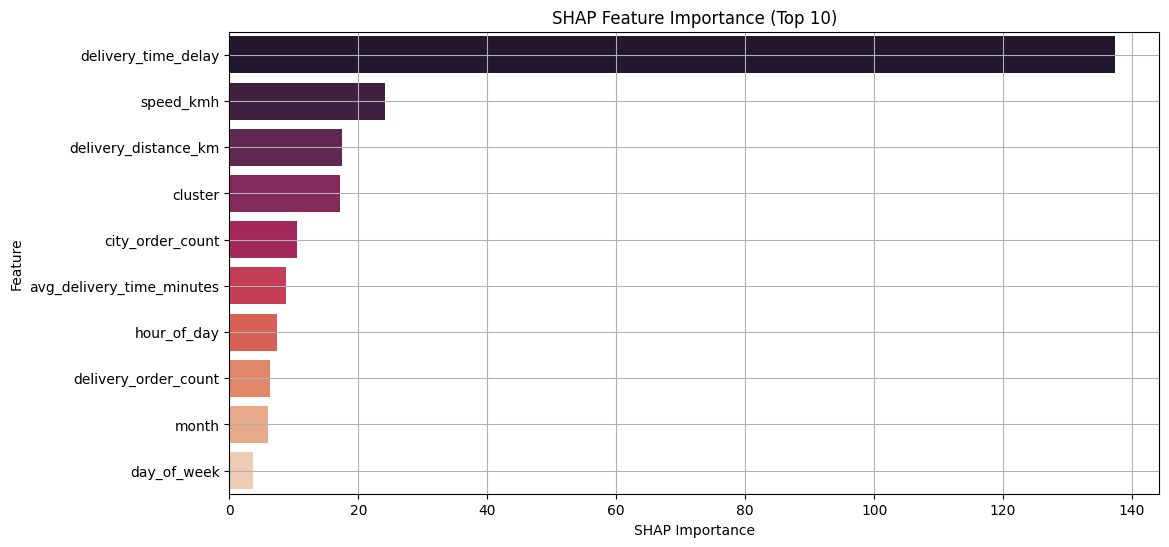

In [12]:
import seaborn as sns

# Convert X_train to DataFrame if not already
# if not isinstance(X_train, pd.DataFrame):
#     X_train = pd.DataFrame(X_train, columns=features) 

# SHAP Feature Importance (Bar Plot)
shap_df = pd.DataFrame({
    "Feature": X_train.columns,
    "SHAP Importance": np.abs(shap_values).mean(axis=0)
})

if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns = feature_names) #feature_names is a list of the column names.

shap_df = shap_df.sort_values(by="SHAP Importance", ascending=False)
print(shap_df.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x="SHAP Importance", y="Feature", data=shap_df.head(10), palette="rocket", hue="Feature", legend=False)
plt.title("SHAP Feature Importance (Top 10)")
plt.grid(True)
plt.show()

##### Key Observations for ETA Prediction:

In [13]:
# Feature SHAP Importance Interpretation
# delivery_time_delay	193.68	The most critical factor — any delay at the delivery stage significantly impacts the ETA.
# speed_kmh	37.20	Slower driving speeds increase ETA — highly influenced by traffic conditions.
# delivery_distance_km	35.14	Longer distances naturally increase ETA, but its impact is lower than delivery delays.
# hour_of_day	2.25	Certain hours (peak traffic hours like morning or evening) increase ETA.
# city_order_count	1.15	Higher demand in the city likely causes longer waiting times and affects the overall ETA.
# delivery_order_count	0.80	More deliverys nearby may result in driver unavailability and longer waiting times.
# avg_delivery_time_minutes	0.68	Higher average delivery times directly increase ETA.
# day_of_week	0.67	Certain days (like weekends or holidays) might show longer ETAs due to higher order volumes.
# month	0.26	Seasonality impact — delays may be longer in holiday seasons or bad weather months.
# cluster	0.19	Some areas (high traffic or remote locations) may consistently have longer ETAs.

##### Hyperparameter Tuning for Random Forest

In [14]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Cache Data for Faster Computation
train_data_features.cache()
test_data_features.cache()

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='delivery_eta_minutes', seed=42, subsamplingRate=0.8)  # 80% Data for Each Tree

# Hyperparameter Grid (Lite Version - Fast Processing)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32]) \
    .build()

# Evaluators
evaluator_rmse = RegressionEvaluator(labelCol='delivery_eta_minutes', predictionCol='prediction', metricName='rmse')
evaluator_mse = RegressionEvaluator(labelCol='delivery_eta_minutes', predictionCol='prediction', metricName='mse')
evaluator_mae = RegressionEvaluator(labelCol='delivery_eta_minutes', predictionCol='prediction', metricName='mae')

# Cross Validator with Parallelism
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator_rmse,
                          numFolds=3,  # Faster Cross Validation
                          parallelism=4,  # Number of Cores for Parallel Jobs
                          seed=42)

# Fit Model
print("Training Model with Hyperparameter Tuning...")
cv_model = crossval.fit(train_data_features)
print("Model Training Done!")

# Best Model
best_rf_model = cv_model.bestModel
print("\n Best Hyperparameters:")
print("numTrees:", best_rf_model.getNumTrees, 
      "maxDepth:", best_rf_model.getMaxDepth(),
      "maxBins:", best_rf_model.getMaxBins())

# Predictions
rf_predictions = best_rf_model.transform(test_data_features)

# Evaluation
rmse = evaluator_rmse.evaluate(rf_predictions)
mse = evaluator_mse.evaluate(rf_predictions)
mae = evaluator_mae.evaluate(rf_predictions)

print("\nModel Performance Metrics:")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)

Training Model with Hyperparameter Tuning...
Model Training Done!

 Best Hyperparameters:
numTrees: 50 maxDepth: 10 maxBins: 32

Model Performance Metrics:
MSE : 482035.8091853962
RMSE: 694.287987210924
MAE : 66.13861451516937


#### Classification models for Delay detection (Logistic Regression, Decision Tree, Neural Networks)

In [15]:
# StringIndexer for is_delayed (Target Column)
indexer_is_delayed = StringIndexer(inputCol='is_delayed', outputCol='label', handleInvalid='keep')

# StringIndexer for speed_status (Categorical Feature)
indexer_speed_status = StringIndexer(inputCol='speed_status', outputCol='speed_status_indexed', handleInvalid='keep')

# Final Feature Columns including speed_status_indexed
feature_cols = ['hour_of_day', 'day_of_week', 'month', 'delivery_eta_minutes', 
                'delivery_time_delay', 'delivery_distance_km', 'cluster', 
                'avg_delivery_time_minutes', 'delivery_order_count', 'city_order_count', 
                'speed_kmh', 'speed_status_indexed']

# Vector Assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features', handleInvalid='skip')

# Pipeline (First Indexer for is_delayed, Second Indexer for speed_status, then Assembler)
pipeline = Pipeline(stages=[indexer_is_delayed, indexer_speed_status, assembler])

# Transform the Train Data
model_data = pipeline.fit(train_data).transform(train_data)

##### Logistic Regression

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Fit Model
lr_model = lr.fit(model_data)
lr_predictions = lr_model.transform(model_data)

# Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
lr_acc = evaluator.evaluate(lr_predictions)

print("Logistic Regression Accuracy:", lr_acc)

Logistic Regression Accuracy: 0.9972193428779927


##### SHAP values & Feature Importance plots

C:\Users\Dusty\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


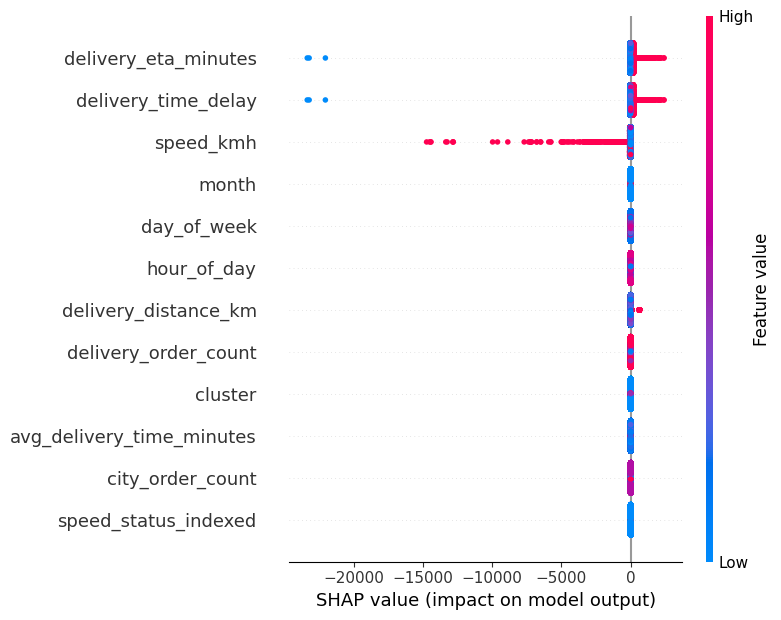

In [17]:
import shap
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Spark DataFrame ko Cache karne ka
model_data = model_data.cache()
model_data = model_data.limit(200000)  # Top 5000 Rows lele

# PySpark DF to Pandas Conversion with Cache
pandas_df = model_data.toPandas()
X = pandas_df['features'].apply(lambda x: x.toArray()).tolist()
X = pd.DataFrame(X, columns=feature_cols)
y = pandas_df['label']

# Sklearn Logistic Regression Model
lr_sklearn = LogisticRegression(max_iter=40000)
lr_sklearn.fit(X, y)

# SHAP Explainer
explainer = shap.Explainer(lr_sklearn, X)
shap_values = explainer(X)

# SHAP Summary Plot
shap.summary_plot(shap_values, X, feature_names=feature_cols)

In [18]:
# SHAP Values Numerical Print
shap_df = pd.DataFrame(shap_values.values, columns=feature_cols)

# every Feature Average Impact (Mean Absolute Value)
shap_importance = shap_df.abs().mean().sort_values(ascending=False).reset_index()
shap_importance.columns = ['Feature', 'Mean_Impact']

# Top 10 Important Features
print("\nTop 10 Important Features According to SHAP:")
print(shap_importance.head(10))


Top 10 Important Features According to SHAP:
                     Feature  Mean_Impact
0       delivery_eta_minutes    16.565144
1        delivery_time_delay    16.565144
2                  speed_kmh     4.071826
3                      month     1.197880
4                day_of_week     0.765105
5                hour_of_day     0.723209
6       delivery_distance_km     0.653095
7       delivery_order_count     0.332988
8                    cluster     0.295485
9  avg_delivery_time_minutes     0.053223


In [19]:
from pyspark.ml.classification import LogisticRegression

final_selected_cols = ['delivery_order_count','delivery_distance_km', 'speed_kmh']
# Vector Assembler for Final Features
assembler_final_selected = VectorAssembler(inputCols=final_selected_cols, outputCol='final_features_selected')

# Transform Data
final_selected_model_data = assembler_final_selected.transform(model_data).select('final_features_selected', 'label')

# Train Logistic Regression
lr_final = LogisticRegression(featuresCol='final_features_selected', labelCol='label')
lr_model_selected = lr_final.fit(final_selected_model_data)

# Predictions
predictions_selected = lr_model_selected.transform(final_selected_model_data)

# Evaluate Again
evaluator_selected = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
final_accuracy = evaluator_selected.evaluate(predictions_selected)
print(f"Final Logistic Regression Accuracy: {final_accuracy * 100:.2f} %")

Final Logistic Regression Accuracy: 89.18 %


##### Hyperparameter tuning for Logistic Regression¶


In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Logistic Regression Model
lr = LogisticRegression(featuresCol='final_features_selected', labelCol='label', family='multinomial')

# Param Grid for Hyperparameter Tuning
paramGrid = (ParamGridBuilder()
             .addGrid(lr.maxIter, [10, 50, 100])
             .addGrid(lr.regParam, [0.0, 0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Correct Evaluator for Multiclass
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Cross Validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit Cross Validation Model
cvModel = crossval.fit(final_selected_model_data)

# Best Model
best_model = cvModel.bestModel
print("Best Parameters:")
print(f"Max Iterations: {best_model._java_obj.getMaxIter()}")
print(f"Reg Param: {best_model._java_obj.getRegParam()}")
print(f"Elastic Net Param: {best_model._java_obj.getElasticNetParam()}")

# Predictions
final_predictions = best_model.transform(final_selected_model_data)

# Final Accuracy
final_acc = evaluator.evaluate(final_predictions)
print(f"Logistic Regression Final Accuracy with Hyperparameter Tuning:", final_acc * 100,"%")

Best Parameters:
Max Iterations: 100
Reg Param: 0.0
Elastic Net Param: 0.0
Logistic Regression Final Accuracy with Hyperparameter Tuning: 89.18350000000001 %


##### Decision Tree

In [21]:
from pyspark.ml.classification import DecisionTreeClassifier

# Model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

# Fit Model
dt_model = dt.fit(model_data)
dt_predictions = dt_model.transform(model_data)

# Evaluation
evaluator_dt = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_acc = evaluator.evaluate(dt_predictions)

print("Decision Tree Accuracy:", dt_acc * 100, "%")

Decision Tree Accuracy: 99.698 %


##### Hyperparameter tuning of Decision Tree

In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F


# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Hyperparameter Grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 3, 5, 6, 10])
             .addGrid(dt.maxBins, [16, 25, 32])
             .build())

# Multiclass Evaluator (For Accuracy)
evaluator = MulticlassClassificationEvaluator(
    labelCol='label', 
    predictionCol='prediction', 
    metricName='accuracy'  # You can also set metricName to 'f1', 'weightedPrecision', 'weightedRecall'
)

# Cross-Validation
crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

# Fit the Model
cvModel = crossval.fit(model_data)
cv_predictions = cvModel.transform(model_data)

# Accuracy Score
final_dt_accuracy = evaluator.evaluate(cv_predictions)
print(f"Final Decision Tree Accuracy:",final_dt_accuracy * 100,"%")

# Additional Metrics
f1_score = evaluator.setMetricName("f1").evaluate(cv_predictions)
precision = evaluator.setMetricName("weightedPrecision").evaluate(cv_predictions)
recall = evaluator.setMetricName("weightedRecall").evaluate(cv_predictions)

print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Final Decision Tree Accuracy: 99.68350000000001 %
F1 Score: 0.9968
Precision: 0.9969
Recall: 0.9968


##### Neural Network

In [29]:
print("Total Rows in model_data:", model_data.count())

Total Rows in model_data: 200000


In [27]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# to make the pocess fast cache the dataframe and Reduce Data Size for Testing Purpose
# model_data_sample = model_data.sample(0.2, seed=42)  # Only 20% data

layers = [len(feature_cols), 64, 32, 2]  # Input, Hidden Layers, Output
mlp = MultilayerPerceptronClassifier(layers=layers, featuresCol='features', labelCol='label', maxIter=50)

mlp_model = mlp.fit(model_data)
mlp_predictions = mlp_model.transform(model_data)

mlp_acc = evaluator.evaluate(mlp_predictions)

print("Neural Network (MLP) Accuracy: ", mlp_acc*100, "%")

Neural Network (MLP) Accuracy:  85.36200000000001 %


##### Hyperparameter tuning of Neural Network

In [28]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# model_data = model_data.select("features", "label")

# # Step 1: Scaling
# scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
# scaler_model = scaler.fit(model_data)
# scaled_data = scaler_model.transform(model_data).select("scaled_features", "label")

# Step 2: Define MLP Classifier
mlp = MultilayerPerceptronClassifier(
    featuresCol='features',
    labelCol='label',
    layers=[12, 8, 4, 2],  # Layers Fixed Based on SHAP
    maxIter=100,
    blockSize=128,
    seed=42
)

# Step 3: Param Grid
paramGrid = (ParamGridBuilder()
             .addGrid(mlp.maxIter, [50, 100, 150])
             .addGrid(mlp.stepSize, [0.01, 0.1])
             .addGrid(mlp.blockSize, [128, 256])
             .build())

# Step 4: Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Step 5: Cross Validation
cv = CrossValidator(estimator=mlp,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3)  # 3-Fold for Better Accuracy

# Step 6: Fit Model
cv_model = cv.fit(model_data)

# Predictions
cv_predictions = cv_model.transform(model_data)

# Accuracy
cv_accuracy = evaluator.evaluate(cv_predictions)
print(f"\nNeural Network Accuracy After Tuning:",cv_accuracy*100,"%")

# Best Hyperparameters
best_model = cv_model.bestModel

print("\nBest Hyperparameters:")
print("Layers: ", best_model.getLayers())
print("Max Iterations: ", best_model.getMaxIter())
print("Step Size: ", best_model.getStepSize())
print("Block Size: ", best_model.getBlockSize())


Neural Network Accuracy After Tuning: 85.36200000000001 %

Best Hyperparameters:
Layers:  [12, 8, 4, 2]
Max Iterations:  150
Step Size:  0.01
Block Size:  128


##### SHAP value and feature Importance plot

In [30]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Convert Spark DataFrame to Pandas
X_pd = model_data.select(feature_cols).toPandas()

# Step 2: MLP Probabilities Extraction
mlp_predictions_pd = mlp_predictions.select("probability").toPandas()
probabilities = np.array([float(x[0][1]) for x in mlp_predictions_pd.values])

# Step 3: Custom Prediction Function
def predict_fn(X):
    return probabilities[:len(X)]

# Step 4: SHAP Explainer (Permutation Explainer)
# explainer = shap.Explainer(predict_fn, X_pd)
# shap_values = explainer(X_pd, max_evals=1000)

background = shap.sample(X_pd, 100000, random_state=42)

explainer = shap.Explainer(predict_fn, background, link=shap.links.identity)
shap_values = explainer(X_pd.sample(100000, random_state=42))
print("SHAP Values Generated")

PermutationExplainer explainer: 100001it [08:50, 185.87it/s]                           


SHAP Values Generated


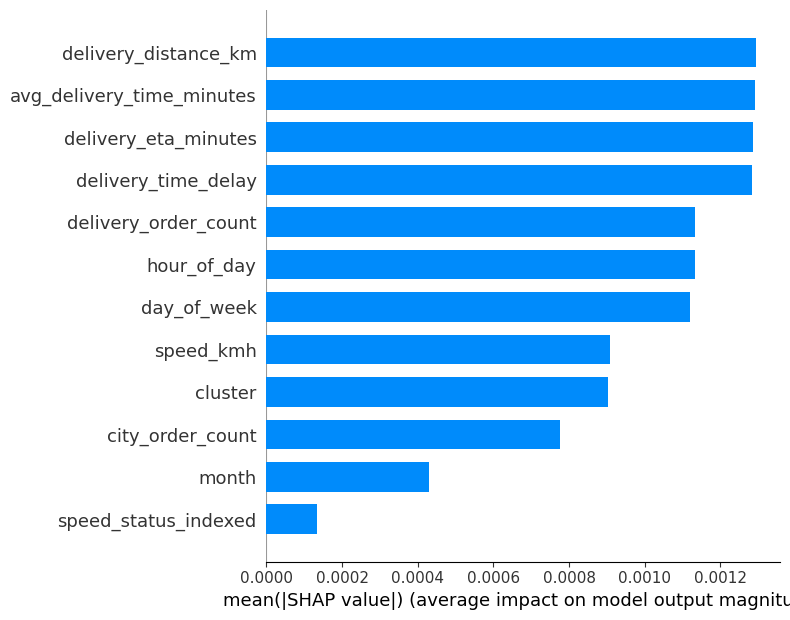

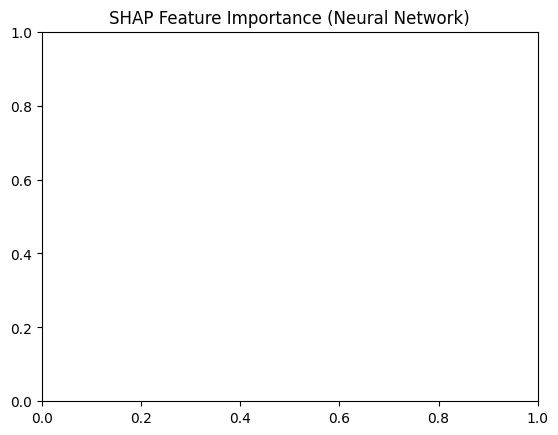


Top 10 Important Features According to SHAP:
                      Feature  Mean_SHAP
5        delivery_distance_km   0.001293
7   avg_delivery_time_minutes   0.001291
3        delivery_eta_minutes   0.001286
4         delivery_time_delay   0.001284
8        delivery_order_count   0.001134
0                 hour_of_day   0.001132
1                 day_of_week   0.001121
10                  speed_kmh   0.000908
6                     cluster   0.000903
9            city_order_count   0.000775


In [31]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_pd, plot_type="bar")
plt.title("SHAP Feature Importance (Neural Network)")
plt.show()

# Top 10 Features
shap_mean = pd.DataFrame({
    "Feature": feature_cols,
    "Mean_SHAP": np.abs(shap_values.values).mean(axis=0)
})

shap_mean = shap_mean.sort_values(by="Mean_SHAP", ascending=False)
print("\nTop 10 Important Features According to SHAP:")
print(shap_mean.head(10))